Initializing lat,lon,alt grid with following parameters:

Epoch, Nvert = 2010.000000, 50.000000

Lat min,max,npts = -90.000000,90.000000,151.000000

Lon min,max,npts = -180.000000,180.000000,251.000000

Alt min,max,npts = 300.000000,900.000000,6.000000

Preparing interpolation tables...
Transforming 3000 points from lat,lon,alt to apex...
Computing 3000 Apex Longitude values to Magnetic Local Time...

Computing 3000 Apex Longitude values to Magnetic Local Time...

Computing 3000 Apex Longitude values to Magnetic Local Time...

Computing 3000 Apex Longitude values to Magnetic Local Time...

Computing 3000 Apex Longitude values to Magnetic Local Time...

Computing 3000 Apex Longitude values to Magnetic Local Time...

Computing 3000 Apex Longitude values to Magnetic Local Time...

Computing 3000 Apex Longitude values to Magnetic Local Time...



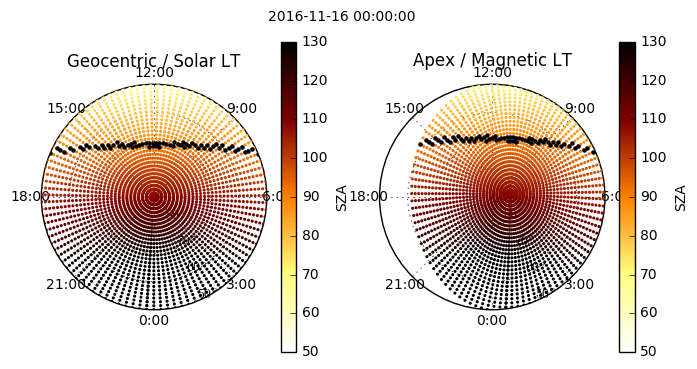

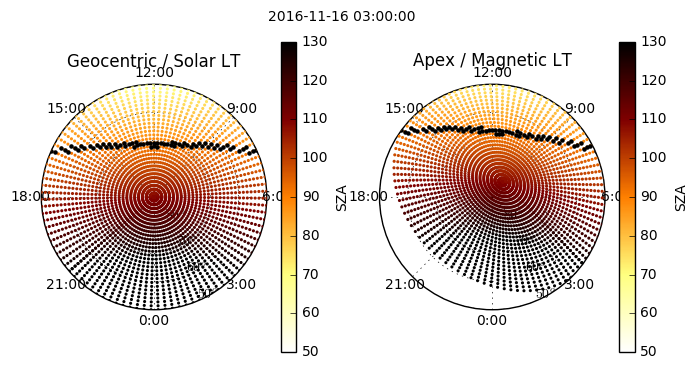

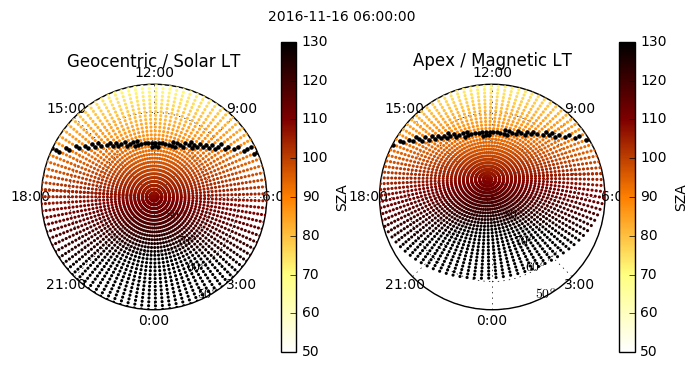

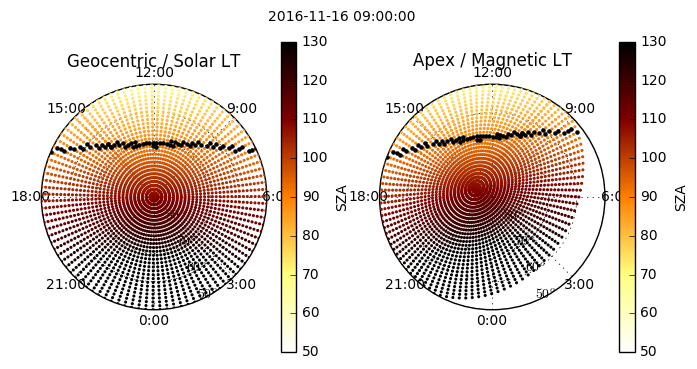

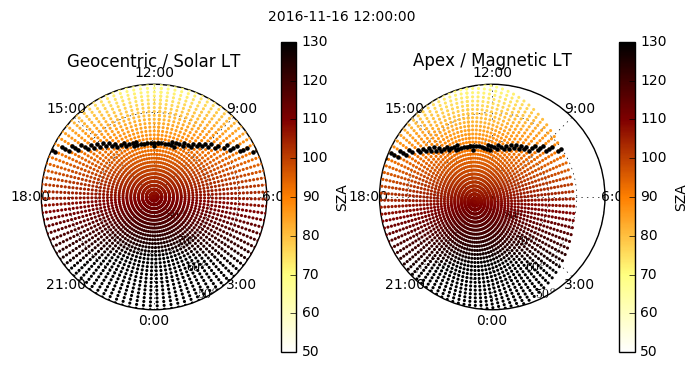

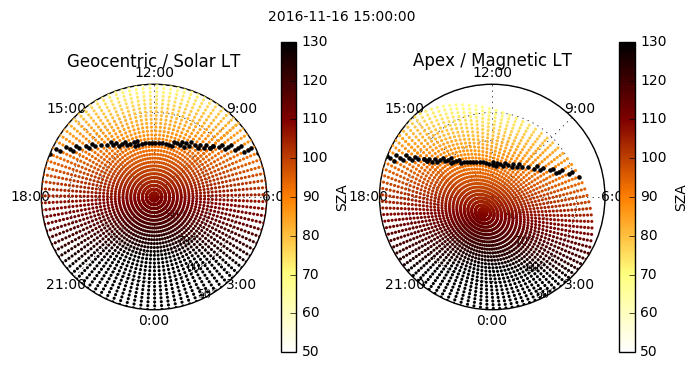

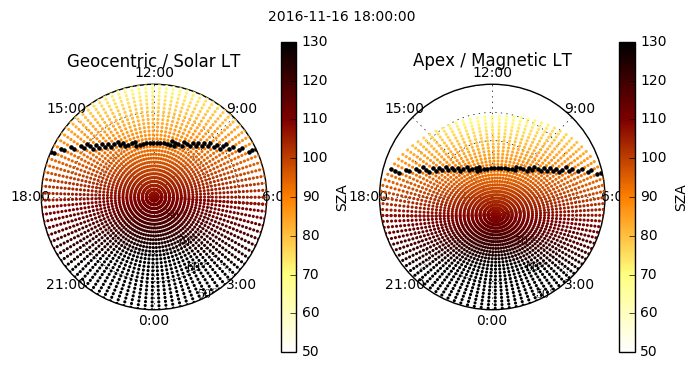

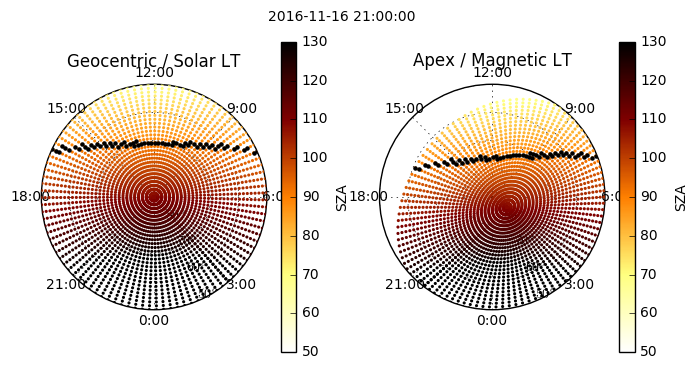

In [5]:
from geospacepy import astrodynamics2,special_datetime
import datetime
import numpy as np
from matplotlib import pyplot as plt

import apexpy
ac = apexpy.apex_converter(epoch=2010,altmin=300.,altmax=900.)
#Make a helper function

def latlt2polar(lat,lt,hemisphere):
    """
    Converts an array of latitude and lt points to polar for a top-down dialplot (latitude in degrees, LT in hours)
    i.e. makes latitude the radial quantity and MLT the azimuthal 

    get the radial displacement (referenced to down from northern pole if we want to do a top down on the north, 
    or up from south pole if visa-versa)
    """
    from numpy import pi
    if hemisphere=='N':
        r = 90.-lat
    elif hemisphere=='S':
        r = 90.-(-1*lat)
    else:
        raise ValueError('%s is not a valid hemisphere, N or S, please!' % (hemisphere))
    #convert lt to theta (azimuthal angle) in radians
    theta = lt/24. * 2*pi

    #the pi/2 rotates the coordinate system from
    #theta=0 at negative y-axis (local time) to
    #theta=0 at positive x axis (traditional polar coordinates)
    return r,theta

def to_dialplot(ax):
    """
    Convert a polar matplotlib axes into a 'dialplot' (top down view of polar region with top pointed towards noon)
    """
    #Rotate the plot so that noon is at the top and midnight
    #is at the bottom, and fix the labels so radial direction
    #is latitude and azimuthal direction is local time in hours
    ax.set_theta_zero_location('S')
    theta_label_values = np.array([0.,3.,6.,9.,12.,15.,18.,21.])*180./12
    theta_labels = ['%d:00' % (int(th/180.*12)) for th in theta_label_values.flatten().tolist()]
    ax.set_thetagrids(theta_label_values,labels=theta_labels)

    r_label_values = 90.-np.array([80.,70.,60.,50.])
    r_labels = [r'$%d^{o}$' % (int(90.-rv)) for rv in r_label_values.flatten().tolist()]
    ax.set_rgrids(r_label_values,labels=r_labels)
    
    ax.set_rlim([0.,40.])

nlats = 30
nlons = 100
lats = np.linspace(50.,90.,nlats)
lons = np.linspace(0,360.,nlons)
grid_lats,grid_lons = np.meshgrid(lats,lons,indexing='ij')
    
#Convert grid coordinates to magnetic time
#geo2apex(self,lat,lon,alt,hr=110.)
#def alon2mlt(self,alon,year,dayofyear,utseconds)
alats,alons,qdlats = ac.geo2apex(grid_lats.flatten(),grid_lons.flatten(),850.*np.ones_like(grid_lats.flatten()))
grid_mlats = alats.reshape(grid_lats.shape)
    
for hour in range(0,24,3):
    dt = datetime.datetime(2016,11,16,hour,0,0)
    
    #Calculate MLT
    grid_mlts = ac.alon2mlt(alons,dt.year,dt.timetuple().tm_yday,dt.hour*3600.)
    grid_mlts.reshape(grid_lons.shape)
    
    #Convert grid_longitudes to solar local times
    grid_lts = astrodynamics2.lon2lt(dt,grid_lons.flatten())
    grid_lts.reshape(grid_lats.shape)
    
    #Calculate solar zenith angles
    #sza_ephem = astrodynamics2.solar_zenith_angle_broken(dt,grid_lats.flatten(),grid_lons.flatten())
    sza_approx = astrodynamics2.solar_zenith_angle(dt,grid_lats.flatten(),grid_lons.flatten())

    #Get polar coordinates for plots
    r_geo,theta_geo = latlt2polar(grid_lats,grid_lts,'N')
    r_apx,theta_apx = latlt2polar(grid_mlats,grid_mlts,'N')

    #Now we can finally try to plot and see what we get
    f = plt.figure(figsize=(8,4))
    ax1 = f.add_subplot(121,projection='polar')
    ax2 = f.add_subplot(122,projection='polar')
    f.suptitle(str(dt))
    
    dot_size = 5
    vmin=90-40
    vmax=90+40
    mappable1 = ax1.scatter(theta_geo,r_geo,dot_size,sza_approx,zorder=10,
                            cmap='afmhot_r',vmin=vmin,vmax=vmax,edgecolor='None')
    mappable2 = ax2.scatter(theta_apx,r_apx,dot_size,sza_approx,zorder=10,
                            cmap='afmhot_r',vmin=vmin,vmax=vmax,edgecolor='None')
    
    #Draw terminator
    term = np.logical_and(sza_approx<91,sza_approx>89)
    ax1.scatter(theta_geo.flatten()[term],r_geo.flatten()[term],dot_size,'k',zorder=12)
    ax2.scatter(theta_apx.flatten()[term],r_apx.flatten()[term],dot_size,'k',zorder=12)
    
    #Convert to dialplot
    to_dialplot(ax1)
    to_dialplot(ax2)

    plt.colorbar(mappable1,ax=ax1,label='SZA')
    plt.colorbar(mappable2,ax=ax2,label='SZA')
    ax1.set_title('Geocentric / Solar LT')
    ax2.set_title('Apex / Magnetic LT')
    
plt.show()

In [ ]:
ac = 